<a href="https://colab.research.google.com/github/themathedges/3YP-Standalone-Kennington/blob/main/Ravi/Old_regressionModel_8_Multivariate_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 8: Multivariate Regression (Daily)

---



**Author:** Ravi Kohli

**Date:** January 13th, 2021

**College:** Christ Church

**Goal:**
- To make a very simple multivariate linear regression monthly model to forecast the future generation profile of Sandford Hydro
- We will use the variables: precipitation and snowfall

In [ ]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import the modules
import numpy as np
import pandas as pd
from pandas import Timestamp
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Collecting the Data

### Defining the Mask

In [ ]:
# extract the rows that we want by using a mask
# format of mask: YYYY-MM-DD
model_8_current_mask_start = pd.to_datetime('2018-12-01')
model_8_current_mask_end = pd.to_datetime('2019-10-22')

### Daily Current Generation

In [ ]:
# unpickle the processed daily generation dataframe
path = '/content/drive/My Drive/3YP/data/'
filename = 'daily_sandford_generation_data'
infile = open(path+filename, 'rb')
sandford_daily_df = pickle.load(infile)
infile.close()

In [ ]:
sandford_daily_df

,Reading Date,Incremental Reading,Meter Reading
0,2019-10-22,1284.10,1763145.53
1,2019-10-21,1175.01,1761861.43
2,2019-10-20,1175.01,NaN
3,2019-10-19,1175.01,NaN
4,2019-10-18,2265.09,1758336.41
...,...,...,...
364,2018-10-22,0.00,548149.91
365,2018-10-21,0.00,548149.91
366,2018-10-20,0.00,548149.91
367,2018-10-19,0.00,548149.91


In [ ]:
model_8_gen_current_mask = (sandford_daily_df['Reading Date'] >= model_8_current_mask_start) & (sandford_daily_df['Reading Date'] <= model_8_current_mask_end)

# extract the rows from the dataframe by using the mask
sandford_gen_df = sandford_daily_df.loc[model_8_gen_current_mask]

In [ ]:
sandford_gen_df

,Reading Date,Incremental Reading,Meter Reading
0,2019-10-22,1284.100,1763145.53
1,2019-10-21,1175.010,1761861.43
2,2019-10-20,1175.010,NaN
3,2019-10-19,1175.010,NaN
4,2019-10-18,2265.090,1758336.41
...,...,...,...
320,2018-12-05,12.493,551201.08
321,2018-12-04,0.000,551188.58
322,2018-12-03,0.000,551188.58
323,2018-12-02,2.765,551188.58


### Daily Temperature Data

In [ ]:
# unpickle the temperature daily dataframe
path = '/content/drive/My Drive/3YP/data/'
filename = 'radcliffe_daily_temperature_data_processed'
infile = open(path+filename, 'rb')
temperature_daily_df = pickle.load(infile)
infile.close()

In [ ]:
model_8_temp_current_mask = (temperature_daily_df['Date'] >= model_8_current_mask_start) & (temperature_daily_df['Date'] <= model_8_current_mask_end)

# extract the rows from the dataframe by using the mask
temp_current_df = temperature_daily_df.loc[model_8_temp_current_mask]

### Daily Precipitation (Grid square 1)

In [ ]:
# unpickle the current precipitation daily dataframe
path = '/content/drive/My Drive/3YP/data/'
filename = 'radcliffe_daily_precipitation_data_processed'
infile = open(path+filename, 'rb')
precipitation_daily_df = pickle.load(infile)
infile.close()

In [ ]:
model_8_precip_current_mask = (precipitation_daily_df['Date'] >= model_8_current_mask_start) & (precipitation_daily_df['Date'] <= model_8_current_mask_end)

# extract the rows from the dataframe by using the mask
precipitation_current_df = precipitation_daily_df.loc[model_8_precip_current_mask]

### Upstream Daily Precipitation (Grid square 2)

In [ ]:
# unpickle the current upstream precipitation daily dataframe
path = '/content/drive/My Drive/3YP/data/met_office/'
filename = 'precip_2242_upstream2_met_daily'
infile = open(path+filename, 'rb')
precipitation_upstream2_daily_df = pickle.load(infile)
infile.close()

In [ ]:
# define the lag between precipitation at the upstream location and the generation at Sandford Hydro
upstream_2_lag = 15

# define this as a datetime.timedelta so that we can subtract it from the starting date of the mask
dt_upstream2 = datetime.timedelta(upstream_2_lag)

In [ ]:
model_8_precip_upstream2_current_mask = ((precipitation_upstream2_daily_df['Date'] >= (model_8_current_mask_start)) &       
                              (precipitation_upstream2_daily_df['Date'] <= model_8_current_mask_end + dt_upstream2))

# extract the rows from the dataframe by using the mask
upstream2_current_df = precipitation_upstream2_daily_df.loc[model_8_precip_upstream2_current_mask]

In [ ]:
# create the new column with shifted data
upstream2_current_df['Shifted_rain'] = upstream2_current_df['Precipitation'].shift(-upstream_2_lag) 
#upstream2_current_df['Shifted_rain'] = upstream2_current_df['Precipitation']

# then drop the rows with the NaNs in it
upstream2_current_df.dropna(inplace=True)

# reset the index
upstream2_current_df.reset_index(inplace=True, drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
upstream2_current_df.head(25)

,Date,Precipitation,Shifted_rain
0,2018-12-01,0.005130,0.550614
1,2018-12-02,6.378123,0.102731
2,2018-12-03,5.639075,14.503852
3,2018-12-04,1.404437,2.046431
4,2018-12-05,0.286305,0.500534
5,2018-12-06,12.397127,0.101818
6,2018-12-07,42.307167,0.343483
7,2018-12-08,0.089192,0.019884
8,2018-12-09,0.000051,0.006645
9,2018-12-10,14.991931,0.006444


### Upstream Daily Precipitation (Grid square 3)

In [ ]:
# unpickle the current upstream precipitation daily dataframe
path = '/content/drive/My Drive/3YP/data/met_office/'
filename = 'precip_2242_upstream3_met_daily'
infile = open(path+filename, 'rb')
precipitation_upstream3_daily_df = pickle.load(infile)
infile.close()

In [ ]:
# define the lag between precipitation at the upstream location and the generation at Sandford Hydro
upstream_3_lag = -20

# define this as a datetime.timedelta so that we can subtract it from the starting date of the mask
dt_upstream3 = datetime.timedelta(upstream_3_lag)

In [ ]:
model_8_precip_upstream3_current_mask = ((precipitation_upstream3_daily_df['Date'] >= (model_8_current_mask_start + dt_upstream3)) &       
                              (precipitation_upstream3_daily_df['Date'] <= (model_8_current_mask_end)))

# extract the rows from the dataframe by using the mask
upstream3_current_df = precipitation_upstream3_daily_df.loc[model_8_precip_upstream3_current_mask]

In [ ]:
# create the new column with shifted data
upstream3_current_df['Shifted_rain'] = upstream3_current_df['Precipitation'].shift(-upstream_3_lag) 
#upstream3_current_df['Shifted_rain'] = upstream3_current_df['Precipitation'].shift(-upstream_3_lag) 

# then drop the rows with the NaNs in it
upstream3_current_df.dropna(inplace = True)

# reset the index
upstream3_current_df.reset_index(inplace=True, drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
upstream3_current_df.head(25)

,Date,Precipitation,Shifted_rain
0,2018-12-01,0.005130,0.051777
1,2018-12-02,6.378123,11.928691
2,2018-12-03,5.639075,0.000438
3,2018-12-04,1.404437,0.601514
4,2018-12-05,0.286305,5.490760
5,2018-12-06,12.397127,4.843755
6,2018-12-07,42.307167,0.002106
7,2018-12-08,0.089192,5.114188
8,2018-12-09,0.000051,0.429344
9,2018-12-10,14.991931,0.599768


### Daily Snowfall data: current

In [ ]:
# unpickle the snowfall daily dataframe
path = '/content/drive/My Drive/3YP/data/met_office/'
filename = 'snowfall_2242_met_daily'
infile = open(path+filename, 'rb')
snowfall_daily_df = pickle.load(infile)
infile.close()

In [ ]:
snowfall_daily_df

,Date,Snowfall
0,1980-12-01,0.047270
1,1980-12-02,0.050254
2,1980-12-03,1.431502
3,1980-12-04,0.241387
4,1980-12-05,0.460901
...,...,...
25225,2050-12-26,0.000000
25226,2050-12-27,0.000000
25227,2050-12-28,0.000000
25228,2050-12-29,0.000000


In [ ]:
model_8_snow_current_mask = (snowfall_daily_df['Date'] >= model_8_current_mask_start) & (snowfall_daily_df['Date'] <= model_8_current_mask_end)

# extract the rows from the dataframe by using the mask
snowfall_current = snowfall_daily_df.loc[model_8_snow_current_mask]

In [ ]:
snowfall_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 13680 to 14001
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      320 non-null    datetime64[ns]
 1   Snowfall  320 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.5 KB


### Future Precipitation data (grid square 1)

In [ ]:
# unpickle the future precipitation dataframe
path = '/content/drive/My Drive/3YP/data/met_office/'
filename = 'precip_2242_met_daily' 
infile = open(path+filename, 'rb')
precipitation_future_df = pickle.load(infile)
infile.close()

In [ ]:
# extract the rows that we want by using a mask
# format of mask: YYYY-MM-DD
model_8_future_mask_start = pd.to_datetime('2050-01-01')
model_8_future_mask_end = pd.to_datetime('2050-12-31')

In [ ]:
model_8_precip_future_mask = (precipitation_future_df['Date'] >= model_8_future_mask_start) & (precipitation_future_df['Date'] <= model_8_future_mask_end)

# extract the rows from the dataframe by using the mask
precipitation_future = precipitation_future_df.loc[model_8_precip_future_mask]

In [ ]:
precipitation_future

,Date,Precipitation Rate
24870,2050-01-01,10.622042
24871,2050-01-02,26.987028
24872,2050-01-03,11.353615
24873,2050-01-04,0.251311
24874,2050-01-05,1.852849
...,...,...
25225,2050-12-26,0.000615
25226,2050-12-27,5.991373
25227,2050-12-28,4.328137
25228,2050-12-29,0.100387


### Future precipitation data (grid square 2)

In [ ]:
# unpickle the future precipitation dataframe
path = '/content/drive/My Drive/3YP/data/met_office/'
filename = 'precip_2242_upstream2_met_daily' 
infile = open(path+filename, 'rb')
upstream2_future_df = pickle.load(infile)
infile.close()

In [ ]:
model_8_upstream2_future_mask = (upstream2_future_df['Date'] >= (model_8_future_mask_start)) & (upstream2_future_df['Date'] <= (model_8_future_mask_end + dt_upstream2))

# extract the rows from the dataframe by using the mask
upstream2_future_extracted = upstream2_future_df.loc[model_8_upstream2_future_mask]

In [ ]:
# create the new column with shifted data
upstream2_future_extracted['Shifted_rain'] = upstream2_future_extracted['Precipitation'].shift(-upstream_2_lag) 
#upstream2_future_extracted['Shifted_rain'] = upstream2_future_extracted['Rainfall mm 1 dpl no traces'].shift(upstream_2_lag) 

# then drop the rows with the NaNs in it
upstream2_future_extracted.dropna(inplace = True)

# then reset the index
upstream2_future_extracted.reset_index(inplace = True, drop = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
upstream2_future_extracted

,Date,Precipitation,Shifted_rain
0,2050-01-01,13.178119,0.787618
1,2050-01-02,24.076092,0.185518
2,2050-01-03,11.207090,0.004882
3,2050-01-04,0.225252,0.043175
4,2050-01-05,2.229849,0.107144
...,...,...,...
338,2050-12-11,3.257737,0.002720
339,2050-12-12,0.924931,6.750660
340,2050-12-13,0.268443,3.676629
341,2050-12-14,0.710847,0.092938


### Future Temperature Data

In [ ]:
# unpickle the future temperature dataframe
path = '/content/drive/My Drive/3YP/data/met_office/'
filename = 'temp_2242_met_daily'
infile = open(path+filename, 'rb')
temperature_future_df = pickle.load(infile)
infile.close()

In [ ]:
temperature_future_df

,Date,Temperature
0,1980-12-01,-0.965012
1,1980-12-02,-0.719904
2,1980-12-03,0.271304
3,1980-12-04,-5.000383
4,1980-12-05,-3.902606
...,...,...
25225,2050-12-26,8.359898
25226,2050-12-27,8.109031
25227,2050-12-28,7.250457
25228,2050-12-29,7.026456


In [ ]:
model_8_temp_future_mask = (temperature_future_df['Date'] >= model_8_future_mask_start) & (temperature_future_df['Date'] <= model_8_future_mask_end)

# extract the rows from the dataframe by using the mask
temperature_future = temperature_future_df.loc[model_8_temp_future_mask]

### Future precipitation data (grid square 3)

In [ ]:
# unpickle the future precipitation dataframe
path = '/content/drive/My Drive/3YP/data/met_office/'
filename = 'precip_2242_upstream3_met_daily' 
infile = open(path+filename, 'rb')
upstream3_future_df = pickle.load(infile)
infile.close()

In [ ]:
model_8_upstream3_future_mask = (upstream3_future_df['Date'] >= (model_8_future_mask_start + dt_upstream3)) & (upstream3_future_df['Date'] <= model_8_future_mask_end)

# extract the rows from the dataframe by using the mask
upstream3_future_extracted = upstream3_future_df.loc[model_8_upstream3_future_mask]

In [ ]:
# create the new column with shifted data
upstream3_future_extracted['Shifted_rain'] = upstream3_future_extracted['Precipitation'].shift(-upstream_3_lag - 1) 

# then drop the rows with the NaNs in it
upstream3_future_extracted.dropna(inplace = True)

# then reset the index
upstream3_future_extracted.reset_index(inplace = True, drop = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
upstream3_future_extracted

,Date,Precipitation,Shifted_rain
0,2050-01-01,13.178119,1.161428
1,2050-01-02,24.076092,0.026203
2,2050-01-03,11.207090,0.025171
3,2050-01-04,0.225252,6.493893
4,2050-01-05,2.229849,0.082891
...,...,...,...
353,2050-12-26,0.002720,0.101310
354,2050-12-27,6.750660,1.417610
355,2050-12-28,3.676629,2.695016
356,2050-12-29,0.092938,3.010752


### Future Snowfall data

In [ ]:
model_8_snow_future_mask = (snowfall_daily_df['Date'] >= model_8_future_mask_start) & (snowfall_daily_df['Date'] <= model_8_future_mask_end)

# extract the rows from the dataframe by using the mask
snow_future = snowfall_daily_df.loc[model_8_snow_future_mask]

## Multivariate Regression Analysis

In [ ]:
model_8 = LinearRegression()

In [ ]:
upstream3_current_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           320 non-null    datetime64[ns]
 1   Precipitation  320 non-null    float64       
 2   Shifted_rain   320 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 7.6 KB


### Training and Testing Data

In [ ]:
# note the indexing as we need to exclude november and start the data as december
model_8_train_df = pd.DataFrame([precipitation_current_df['Date']]).T
model_8_train_df['Mean_temp'] = temp_current_df['Daily Tmean °C']
model_8_train_df['Total_precip'] = precipitation_current_df['Rainfall mm 1 dpl no traces']

In [ ]:
# define a set of dates that need to be removed from the rest of the training data sets
dates_to_remove = set(model_8_train_df['Date']) - (set(snowfall_current['Date']))
dates_to_remove

{Timestamp('2018-12-31 00:00:00'),
 Timestamp('2019-01-31 00:00:00'),
 Timestamp('2019-03-31 00:00:00'),
 Timestamp('2019-05-31 00:00:00'),
 Timestamp('2019-07-31 00:00:00'),
 Timestamp('2019-08-31 00:00:00')}

In [ ]:
# remove the row with the extra date from the snowfall data
snowfall_current_removed = snowfall_current[snowfall_current['Date'] != '2019-06-01 00:00:00']

# remove the row with the extra date from the training data
model_8_train = model_8_train_df[model_8_train_df['Date'] != '2019-06-01 00:00:00']
model_8_train['Total_daily_generation'] = sandford_gen_df['Incremental Reading'].values[::-1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# now we want to exclude the row whose date isn't in the generation data
for i in dates_to_remove:
  model_8_train = model_8_train[model_8_train['Date'] != i]

In [ ]:
# reset the indices to try and align them
snowfall_current_removed.reset_index(drop = True)
model_8_train.reset_index(drop = True)

,Date,Mean_temp,Total_precip,Total_daily_generation
0,2018-12-01,9.9,3.1,1272.220
1,2018-12-02,11.6,1.0,2.765
2,2018-12-03,11.8,2.7,0.000
3,2018-12-04,5.3,8.5,0.000
4,2018-12-05,7.6,0.0,12.493
...,...,...,...,...
314,2019-10-18,11.3,0.2,2265.090
315,2019-10-19,11.1,0.0,1175.010
316,2019-10-20,8.1,0.0,1175.010
317,2019-10-21,10.8,0.0,1175.010


In [ ]:
# the .to_numpy() argument is used to bypass the problems due to index misalignment
model_8_train['Snowfall'] = snowfall_current_removed['Snowfall'].to_numpy()
model_8_train['Upstream2_precip'] = upstream2_current_df['Shifted_rain'].to_numpy()

In [ ]:
# find out which date Upstream3_current_df has that model_8_train doesn't have
upstream3_extra_date = set(upstream3_current_df['Date']) - set(model_8_train['Date'])
list(upstream3_extra_date)[0]

Timestamp('2019-06-01 00:00:00')

In [ ]:
# remove this extra date from upstream3_current_df
upstream3_extracted_df = upstream3_current_df[upstream3_current_df['Date'] != list(upstream3_extra_date)[0]]

In [ ]:
# now we can add the upstream3 precipitation column to model_8_train
model_8_train['Upstream3_precip'] = upstream3_extracted_df['Shifted_rain'].to_numpy()

In [ ]:
model_8_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 74479 to 74804
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    319 non-null    datetime64[ns]
 1   Mean_temp               319 non-null    float64       
 2   Total_precip            319 non-null    float64       
 3   Total_daily_generation  319 non-null    float64       
 4   Snowfall                319 non-null    float64       
 5   Upstream2_precip        319 non-null    float64       
 6   Upstream3_precip        319 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 19.9 KB


In [ ]:
model_8_train

,Date,Mean_temp,Total_precip,Total_daily_generation,Snowfall,Upstream2_precip,Upstream3_precip
74479,2018-12-01,9.9,3.1,1272.220,0.000000,5.506137e-01,0.051777
74480,2018-12-02,11.6,1.0,2.765,0.000099,1.027313e-01,11.928691
74481,2018-12-03,11.8,2.7,0.000,0.000000,1.450385e+01,0.000438
74482,2018-12-04,5.3,8.5,0.000,0.000000,2.046431e+00,0.601514
74483,2018-12-05,7.6,0.0,12.493,0.079186,5.005344e-01,5.490760
...,...,...,...,...,...,...,...
74800,2019-10-18,11.3,0.2,2265.090,0.000000,9.969548e-01,0.024800
74801,2019-10-19,11.1,0.0,1175.010,0.000000,4.250000e-07,0.739192
74802,2019-10-20,8.1,0.0,1175.010,0.000000,2.628385e-01,0.048965
74803,2019-10-21,10.8,0.0,1175.010,0.000000,2.480675e+00,0.276037


In [ ]:
# get the training features and target vector
x_train = model_8_train[['Mean_temp', 'Total_precip', 'Snowfall', 'Upstream2_precip', 'Upstream3_precip']]
y_train = model_8_train['Total_daily_generation']

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 74479 to 74804
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Mean_temp         319 non-null    float64
 1   Total_precip      319 non-null    float64
 2   Snowfall          319 non-null    float64
 3   Upstream2_precip  319 non-null    float64
 4   Upstream3_precip  319 non-null    float64
dtypes: float64(5)
memory usage: 15.0 KB


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = 0.40, random_state=42)

### Prediction Data

In [ ]:
temperature_future

,Date,Temperature
24870,2050-01-01,12.811341
24871,2050-01-02,11.466982
24872,2050-01-03,11.742976
24873,2050-01-04,5.330974
24874,2050-01-05,2.696981
...,...,...
25225,2050-12-26,8.359898
25226,2050-12-27,8.109031
25227,2050-12-28,7.250457
25228,2050-12-29,7.026456


In [ ]:
# form the testing data dataframe
model_8_predict_df = temperature_future[['Date', 'Temperature']]
model_8_predict_df['Future_precip'] = precipitation_future['Precipitation Rate']
model_8_predict_df.columns = ['Date', 'Future_temp', 'Future_precip']
model_8_predict_df['Future_snowfall'] = snow_future['Snowfall'].fillna(0)

In [ ]:
# there is a list of dates that need to be removed because the future data for upstream 2 ends at 12-31-2050 and has no 2051 data
test_dates_remove = set(model_8_predict_df['Date']) - set(upstream2_future_extracted['Date']) 
test_dates_remove

{Timestamp('2050-12-16 00:00:00'),
 Timestamp('2050-12-17 00:00:00'),
 Timestamp('2050-12-18 00:00:00'),
 Timestamp('2050-12-19 00:00:00'),
 Timestamp('2050-12-20 00:00:00'),
 Timestamp('2050-12-21 00:00:00'),
 Timestamp('2050-12-22 00:00:00'),
 Timestamp('2050-12-23 00:00:00'),
 Timestamp('2050-12-24 00:00:00'),
 Timestamp('2050-12-25 00:00:00'),
 Timestamp('2050-12-26 00:00:00'),
 Timestamp('2050-12-27 00:00:00'),
 Timestamp('2050-12-28 00:00:00'),
 Timestamp('2050-12-29 00:00:00'),
 Timestamp('2050-12-30 00:00:00')}

In [ ]:
model_8_predict = model_8_predict_df                      # defining a dummy df for use in the iteration beloe
upstream3_reduced = upstream3_future_extracted      # defining a dummy df for use in the iteration beloe


# now we want to exclude the row whose date isn't in the upstream2 future data
for i in test_dates_remove:
  model_8_predict = model_8_predict[model_8_predict['Date'] != i]
  upstream3_reduced = upstream3_reduced[upstream3_reduced['Date'] != i]

In [ ]:
model_8_predict = model_8_predict.reset_index(drop = True)
model_8_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             343 non-null    datetime64[ns]
 1   Future_temp      343 non-null    float64       
 2   Future_precip    343 non-null    float64       
 3   Future_snowfall  343 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 10.8 KB


In [ ]:
model_8_predict['future_Upstream2_precip'] = upstream2_future_extracted['Shifted_rain'].to_numpy()
model_8_predict['future_Upstream3_precip'] = upstream3_reduced['Shifted_rain'].to_numpy()

In [ ]:
model_8_predict

,Date,Future_temp,Future_precip,Future_snowfall,future_Upstream2_precip,future_Upstream3_precip
0,2050-01-01,12.811341,10.622042,0.00000,0.787618,1.161428
1,2050-01-02,11.466982,26.987028,0.00000,0.185518,0.026203
2,2050-01-03,11.742976,11.353615,0.00000,0.004882,0.025171
3,2050-01-04,5.330974,0.251311,0.00013,0.043175,6.493893
4,2050-01-05,2.696981,1.852849,0.00000,0.107144,0.082891
...,...,...,...,...,...,...
338,2050-12-11,5.755041,3.111850,0.00000,0.002720,18.357517
339,2050-12-12,4.982379,0.712024,0.00000,6.750660,7.239441
340,2050-12-13,4.512136,0.279715,0.00000,3.676629,0.431601
341,2050-12-14,2.907415,0.522372,0.00000,0.092938,7.823548


### Actual Prediction

In [ ]:
# train the model
model_8.fit(X_train, Y_train)
print(model_8.intercept_, model_8.coef_)

8363.095660540475 [-379.68515401   16.29873494 -223.57976702  -57.32123429   -1.29772706]


In [ ]:
# calculate the determination score
model_8.score(X_train, Y_train)

0.4780208079352194

In [ ]:
# calculate the prediction on the test set
Y_test_pred = model_8.predict(X_test)

In [ ]:
# calculate the mean squared error of this model
mse_test = mean_squared_error(Y_test_pred, Y_test)
mae_test = mean_absolute_error(Y_test_pred, Y_test)
print("The MAE is:", mae_test)

The MAE is: 2011.1045902155718


In [ ]:
Y_test_pred

array([5628.58603082,  804.06388048, 5554.08676839, 2435.72176923,
       5666.18333631, 4201.96900754, 3505.78563144, 4578.50643341,
       6885.85553693, 4207.90449101, 2363.65357954, 5563.81753059,
       4260.5253711 , 2095.49624522,  554.97594769, 4856.28014219,
       3272.70339171, 5203.61259304, 4018.73430404,  654.95345202,
       2363.51632704, 1825.26229666, 2818.13926555, 4505.60575791,
       4564.61883913, 5530.74512386, 3373.08920949, 7860.56559787,
       4006.28151467, 3287.52469254, 4923.26697816, 4238.66883577,
       2633.0740661 ,  919.66958161, 4755.94384956, 5095.20260766,
       3451.54497689, 2857.18125015, 1344.20679635, 2528.54189387,
       5144.2939969 , 4308.54832162, 3555.98946473, 2818.26450098,
       7384.82628304, 6371.21906234, 1894.43862094, 1179.36143626,
       1077.57102148, 4298.87657876, 7191.48273386,  218.25423143,
       3615.57201506, 4807.5839844 , 5959.98292934, 3129.85260294,
       5942.5852322 , 8804.62607234, 6886.93277598, 1801.92979

Here is where we incorporate the future data

In [ ]:
# make predictions on the future
y_pred = model_8.predict(model_8_predict[['Future_temp', 'Future_precip', 'Future_snowfall', 'future_Upstream2_precip', 'future_Upstream3_precip']])

In [ ]:
y_pred_corrected = [max(i, 0) for i in y_pred]
model_8_predict['Predicted generation'] = y_pred_corrected
model_8_predict['Generation rolling average'] = model_8_predict['Predicted generation'].rolling(10).mean()
print(sum(y_pred_corrected))

1139920.2177461847


In [ ]:
(1130238.6237810384 - 1211960)/1211960 * 100

-6.742910345140232

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


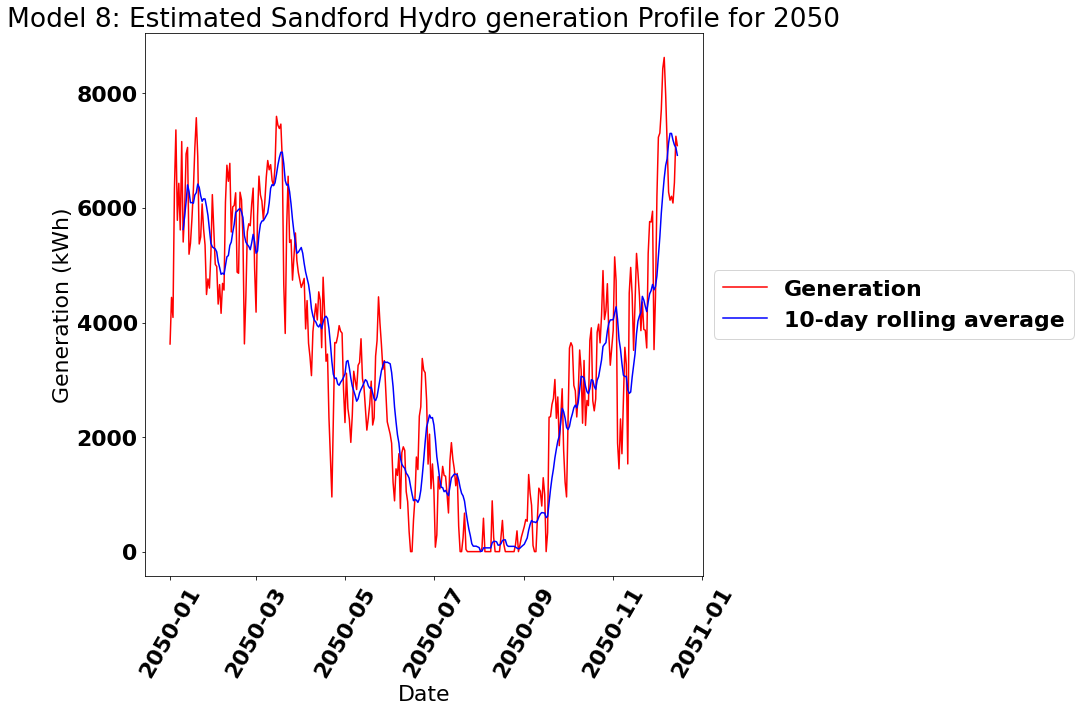

In [ ]:
# Let us plot the generation profile
gen_fig, gen_ax = plt.subplots(figsize = (10, 10))
#gen_ax.plot(sandford_daily_df['Reading Date'], sandford_daily_df['Incremental Reading'], 'r', label = 'Generation')
gen_ax.tick_params(axis='x', rotation=60)
#gen_axplt.xticks(rotation=70
gen_ax.plot(model_8_predict['Date'], model_8_predict['Predicted generation'], 'r', label = 'Generation')  
gen_ax.plot(model_8_predict['Date'], model_8_predict['Generation rolling average'], 'b', label = '10-day rolling average')  

gen_ax.set(title = 'Model 8: Estimated Sandford Hydro generation Profile for 2050', xlabel= 'Date', ylabel='Generation (kWh)')
#gen_ax.set(title = 'Annual Generation (kWh) from Sanford Hydro', xlabel= 'Date', ylabel='Generation (kWh)')
gen_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [ ]:
df.sort_values(by=['Date'], inplace=True, ascending=False)

NameError: ignored

In [ ]:
# create a list of dates with the year 2050
gen_dates_list_2050 = []    # initialise the list

for i in sandford_daily_df['Reading Date'].values:
  i_dt = pd.to_datetime(i)
  i_month = i_dt.month
  i_date = i_dt.day

  # combine to form datetime date
  new_date = datetime.datetime(2050, i_month, i_date)
  gen_dates_list_2050.append(new_date)
  #pd.to_datetime(sandford_daily_df['Reading Date'].values[0]).month

### Corrected Prediction Data

In [ ]:
# make a ceiling to limit the generation
def generation_ceiling(generation_list, maximum_gen):
  gen_list = [i for i in generation_list if i <= maximum_gen]
  return gen_list

In [ ]:
# obtain the generation data after it has been passed through a celing
gen_ceiling = generation_ceiling(y_pred_corrected, maximum_gen=10000)
print("The generation after passing through a ceiling is", sum(gen_ceiling))

In [ ]:
(1130238.6237810384 - 1600000)/1600000 * 100